<a href="https://colab.research.google.com/github/sachinkun21/Stock_price_prediction/blob/master/IOCL_Predictions_in_Python.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Covering Long Short-Term Memory (LSTM) networks in Python and how we can use them to make predictions!**

In this tutorial, you will see how we can use a time-series model known as Long Short-Term Memory. LSTM models are powerful, especially for retaining a long-term memory, by design, as you will see later. You'll tackle the following topics in this tutorial:
- Understand why would you need to be able to predict stock price movements;
- Download the data - You will be using stock market data gathered from Yahoo finance;
- Split train-test data and also perform some data normalization;
- Go over and apply a few averaging techniques that can be used for one-step ahead predictions;
- Motivate and briefly discuss an LSTM model as it allows to predict more than one-step ahead;
- Predict and visualize future stock market with current data.

The only pre-requisite to this tutorial is that you have a basic understanding of Deep Learning implemnetation using python.

Let's Start!!!

### **Why Do You Need Time Series Models?**
You would like to model stock prices correctly, so as a stock buyer you can reasonably decide when to buy stocks and when to sell them to make a profit. 

This is where time series modelling comes in. You need a robust model that can look at the history of a sequence of data and correctly predict what the future elements of the sequence are going to be.

Using machine learning techniques, we will try to achieve this, develop and test the model in the upcoming sections.

Warning: Stock market prices are highly unpredictable and volatile. This means that there are no consistent patterns in the data that allow you to model stock prices over time near-perfectly. Don't take it from me, take it from Princeton University economist Burton Malkiel, who argues in his 1973 book, "A Random Walk Down Wall Street," that if the market is truly efficient and a share price reflects all factors immediately as soon as they're made public, a blindfolded monkey throwing darts at a newspaper stock listing should do as well as any investment professional.

However, let's not go all the way believing that this is just a stochastic or random process and that there is no hope for machine learning. Let's see if you can at least model the data, so that the predictions you make correlate with the actual behavior of the data. In other words, you don't need the exact stock values of the future, but the stock price movements (that is, if it is going to rise of fall in the near future)

**Importing libraries**

In [1]:
# Make sure that you have all these libaries available to run the code successfully

from pandas_datareader import data
import matplotlib.pyplot as plt
import pandas as pd
import datetime as dt
import urllib.request, json
import os
import numpy as np
import tensorflow as tf # This code has been tested with TensorFlow 1.6
from sklearn.preprocessing import MinMaxScaler


### **Downloading the Data**
You will be using data from the following sources:

1. **Alpha Vantage:** Before you start, however, you will first need an API key, which you can obtain for free [here](https://www.alphavantage.co/support/#api-key). After that, you can assign that key to the api_key variable.

2. **Kaggle:** Download the kaggle data from this [page](https://www.kaggle.com/borismarjanovic/price-volume-data-for-all-us-stocks-etfs). You will need to copy the Stocks folder in the zip file of your project home folder.

In [0]:
# Please change this with your own api key
my_key = '4TZ6V9EQSE010E4M'

Before we go ahead and start downloading the Stock prices data, you need to know that stock prices data usually come in several following categories:

- Open: Opening stock price of the day
- Close: Closing stock price of the day
- High: Highest stock price of the data
- Low: Lowest stock price of the day


**1. Getting Data from Alphavantage**

You will first load in the data from Alpha Vantage. 
1. Since you're going to make use of the American Airlines Stock market prices to make your predictions, you set the ticker to "AAL".
2. Additionally, you also define a url_string, which will return a JSON file with all the stock market data for American Airlines within the last 20 years, and a file_to_save, which will be the file to which you save the data.
3. You'll use the ticker variable that you defined beforehand to help name this file.

Next, you're going to specify a condition: if you haven't already saved data, you will go ahead and grab the data from the URL that you set in url_string; You'll store the date, low, high, volume, close, open values to a pandas DataFrame df and you'll save it to file_to_save. However, if the data is already there, you'll just load it from the CSV.

**2. Getting Data from Kaggle**

Data found on Kaggle is a collection of processed csv files and you don't have to do any preprocessing from you end, so you can directly load the data into a Pandas DataFrame and use it.



In [3]:
def download_data(data_source='kaggle', ticker= 'AAL'):
  
    if data_source=='AlphaVanatage':

          # ====================== Loading Data from Alpha Vantage ==================================
          api_key = my_key

          # JSON file with all the stock market data for AAL from the last 20 years
          url_string = "https://www.alphavantage.co/query?function=TIME_SERIES_DAILY&symbol=%s&outputsize=full&apikey=%s"%(ticker,api_key)

          # file to Save the data
          file_to_save = 'stock_market_data-%s.csv'%ticker
          
          # If you haven't already saved data,
          if  not os.path.exists(file_to_save):

              print("Downloading data from AphaVantage......")
              # Go ahead and grab the data from the url
              with urllib.request.urlopen(url_string) as url:
                    data = json.loads(url.read().decode())

                    # Extracting daily time series data of stock into a dictionary with keys as DateTime and values as resepective stock price
                    data = data['Time Series (Daily)']     

                    # Create empty dataframe to store Data
                    stock_df = pd.DataFrame(columns=['Date','Low','High','Open', 'Close'])

                    # And storing date, low, high, volume, close, open values from dictionary to a Pandas DataFrame
                    for k,v in data.items():
                          # Extracting and Converting date into suitable date time format
                          
                          key = dt.datetime.strptime(k, '%Y-%m-%d')
                          # and stock values
                          values = [key,float(v['3. low']),float(v['2. high']),float(v['1. open']), float(v['4. close'])]

                          # print(key,values)

                          # Storing the data values in our empty dataframe one by one 
                          stock_df = stock_df.append({ 'Date': values[0], 'Low':values[1], 'High':values[2], 'Open':values[3], 'Close': values[4] }, ignore_index= True )

                    print('Data saved to : %s'%file_to_save) 
                    stock_df.to_csv(file_to_save) 

          
          
          # If the data is already there, just load it from the CSV
          else:
              print('File already exists. Loading data from CSV')
              stock_df = pd.read_csv(file_to_save)
    

  

    elif data_source=='Kaggle':

        # ====================== Loading Data from Kaggle ==================================  
        # You will be using HP's data. Feel free to experiment with other data.
        stock_df = pd.read_csv(os.path.join('Stocks','hpq.us.txt'),delimiter=',',usecols=['Date','Open','High','Low','Close'])
        # But while doing so, be careful to have a large enough dataset and also pay attention to the data normalization
        print('Loaded data from the Kaggle repository')

      

    
    else:
        print("Invalid Data Source")
    
    
    return stock_df



# ;et's Call the function and store the dataframe
stock_df = download_data(data_source='AlphaVanatage', ticker= 'AAL')
stock_df.head()

Data saved to : stock_market_data-AAL.csv


,Date,Low,High,Open,Close
0,2020-01-29,26.74,27.4900,26.88,26.80
1,2020-01-28,26.26,27.1150,26.36,26.90
2,2020-01-27,25.37,26.6000,26.57,26.11
3,2020-01-24,27.01,28.8612,28.85,27.64
4,2020-01-23,26.04,28.9900,27.39,28.80


### **Data Exploration**
Here you will print the data you collected in to the DataFrame. You should also make sure that the data is sorted by date, because the order of the data is crucial in time series modelling.

In [4]:
stock_df.shape

(3609, 5)

In [5]:
# printing top 5 rows of dataframe
stock_df.head()

,Date,Low,High,Open,Close
0,2020-01-29,26.74,27.4900,26.88,26.80
1,2020-01-28,26.26,27.1150,26.36,26.90
2,2020-01-27,25.37,26.6000,26.57,26.11
3,2020-01-24,27.01,28.8612,28.85,27.64
4,2020-01-23,26.04,28.9900,27.39,28.80


In [6]:
# Printing column info
stock_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3609 entries, 0 to 3608
Data columns (total 5 columns):
Date     3609 non-null datetime64[ns]
Low      3609 non-null float64
High     3609 non-null float64
Open     3609 non-null float64
Close    3609 non-null float64
dtypes: datetime64[ns](1), float64(4)
memory usage: 141.1 KB


In [7]:
# Sort DataFrame by date and reset index
stock_df = stock_df.sort_values('Date').reset_index(drop= True)

# Reprinting the df to check
stock_df.head()

,Date,Low,High,Open,Close
0,2005-09-27,19.10,21.40,21.05,19.30
1,2005-09-28,19.20,20.53,19.30,20.50
2,2005-09-29,20.10,20.58,20.40,20.21
3,2005-09-30,20.18,21.05,20.26,21.01
4,2005-10-03,20.90,21.75,20.90,21.50


DF Looks alright. Let's move ahead to next section

### **Data Visualization**
Now let's see what sort of data you have. You want data with various patterns occurring over time.

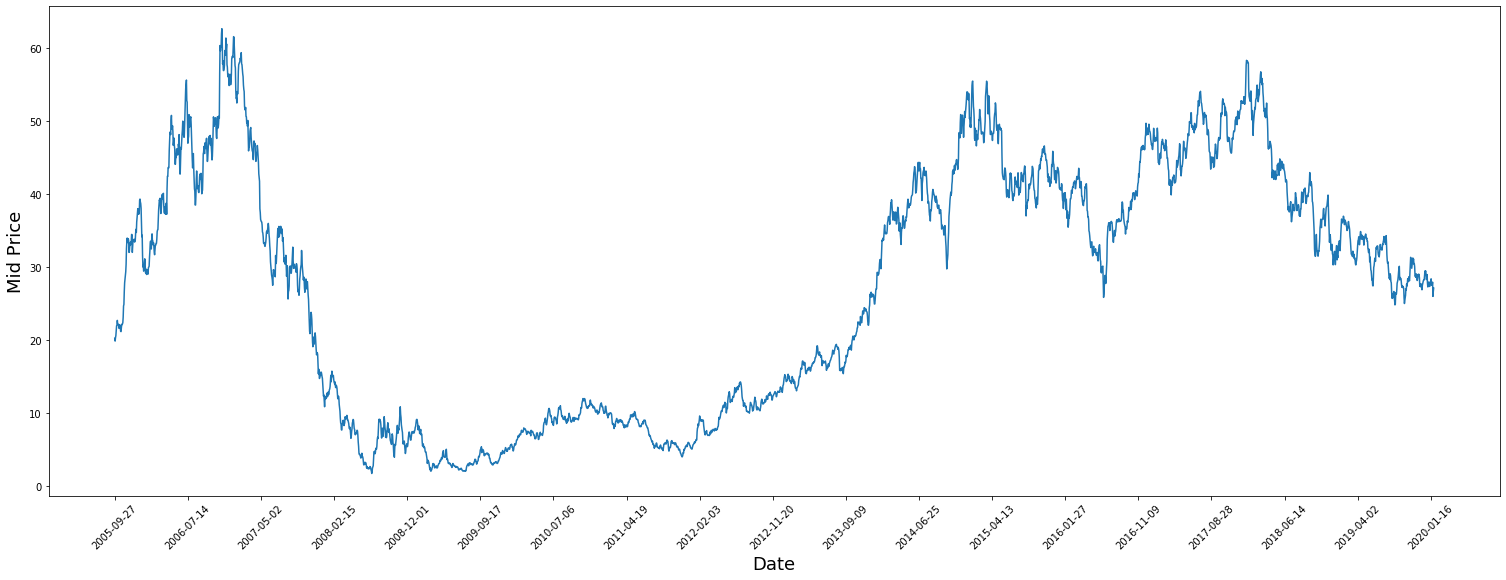

In [8]:
plt.figure(figsize = (26,9))
plt.plot(range(stock_df.shape[0]),(stock_df['Low']+stock_df['High'])/2.0)
plt.xticks(range(0,stock_df.shape[0],200),[i.date() for i in stock_df['Date'].loc[::200]],rotation=45)
plt.xlabel('Date',fontsize=18)
plt.ylabel('Mid Price',fontsize=18)
plt.show()

You can see the behaviour of stock prices of this company from the above time series Graph.
 
 
The specific reason I picked this company over others is that the stocks for this company are shwoing different behaviors over different intervals of time. This will make the learning more robust as well as give you a change to test how good the model predictions are for different kind of situations.

Another thing to notice is that the values close to 2015-2018 are much higher and fluctuate more than the values close to the 2008-2012 indicating the Global Slowdown period. 

Therefore you need to make sure that the data behaves in similar value ranges throughout the time frame. You will take care of this during the data normalization phase.

In [0]:
def plot_array(array):
  pd.Series(array).plot(figsize = (16,6))
  plt.show()


### **Splitting Data into a Training set and a Test set**
You will use the mid price calculated by taking the average of the highest and lowest recorded prices on a day.

In [0]:
# First calculate the mid prices from the highest and lowest
high_prices = stock_df.loc[:,'High'].values
low_prices = stock_df.loc[:,'Low'].values
mid_prices = (high_prices+low_prices)/2.0

Now you can split the training data and test data. The training data will be the first 11,000 data points of the time series and rest will be test data

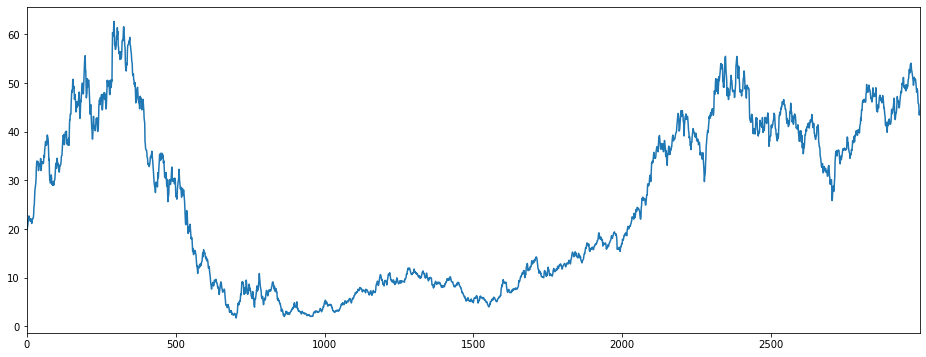

In [11]:
train_data = mid_prices[:3000]
test_data = mid_prices[3000:]
plot_array(train_data)

### **Normalizing the Data**
Now you need to define a scaler to normalize the data. MinMaxScalar scales all the data to be in the region of 0 and 1. You can also reshape the training and test data to be in the shape [data_size, num_features]

In [0]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

Due to the observation you made earlier, that is, different time periods of data have different value ranges, you have to normalize the data by splitting the full series into windows. 

If you don't do this, the earlier data will be close to 0 and will not add much value to the learning process.

Here we will choose a window size of 500.

Tip: when choosing the window size make sure it's not too small, because when you perform windowed-normalization, it can introduce a break at the very end of each window, as each window is normalized independently.

In this example, 5 data points will be affected by this. But given you have 3000 data points, 5 points will not cause any issue


In [13]:
# Train the Scaler with training data and smooth data
smoothing_window_size =  400
for i in range(0,2800, smoothing_window_size):
  scaler.fit(train_data[i:i+smoothing_window_size, :])
  train_data[i:i+smoothing_window_size, :] = scaler.transform(train_data[i:i+smoothing_window_size, :])



# Normalizing the last bit of remaining data if any left out from the loop
scaler.fit(train_data[i+smoothing_window_size:,:])
train_data[i+smoothing_window_size:,:] = scaler.transform(train_data[i+smoothing_window_size:,:])


print(train_data)


[[0.00900164]
 [0.        ]
 [0.01110592]
 ...
 [0.31734579]
 [0.24885442]
 [0.305957  ]]


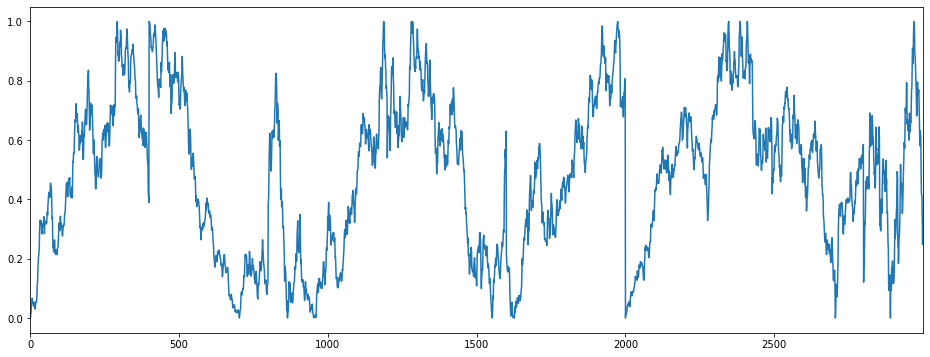

In [14]:
# Reshape both train and test data
train_data = train_data.reshape(-1)
plot_array(train_data)

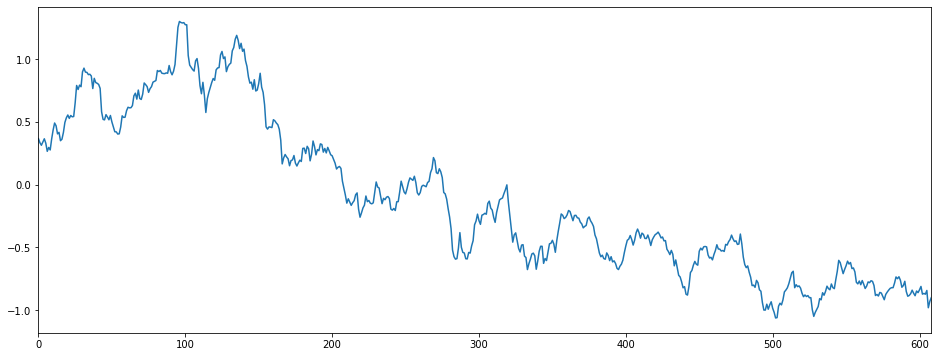

In [15]:
# Let's Normalize test data
test_data = scaler.transform(test_data).reshape(-1)
plot_array(test_data)

### Smoothening the Curve: Exponential Moving Average
You can now smooth the data using the exponential moving average. This helps you to get rid of the inherent raggedness of the data in stock prices and produce a smoother curve.

Note that you should only smooth training data.

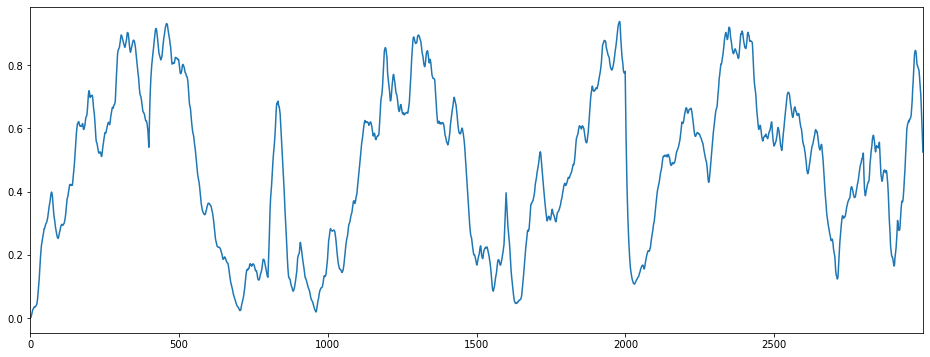

In [16]:
# Now perform exponential moving average smoothing
# So the data will have a smoother curve than the original ragged data

EMA = 0.0
gamma = 0.1

for ti in range(0,len(train_data)):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

plot_array(train_data)

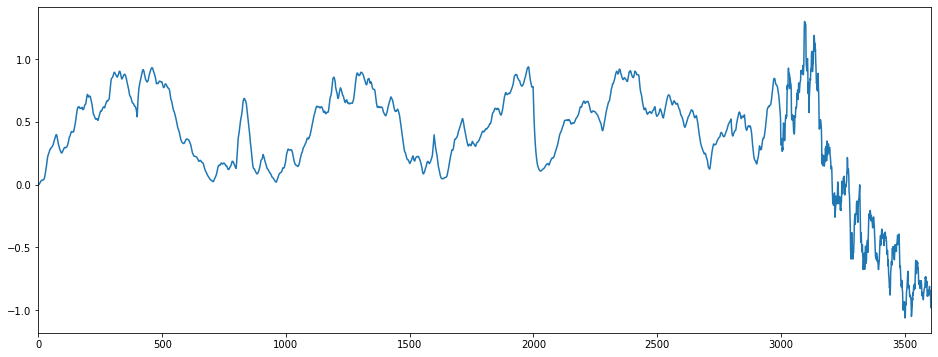

In [17]:
# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

# Plotting the whole array
plot_array(all_mid_data)

## **Modeling**
We will start the Modeling by trying out the Averaging methods considering the prediction problem as average calculation problem.

Then we will move on to the "holy-grail" of time-series prediction; `Long Short-Term Memory ` models.


### **One-Step Ahead Prediction via Averaging**
Averaging mechanisms allow you to predict (often one time step ahead) by representing the future stock price as an average of the previously observed stock prices. Doing this for more than one time step can produce quite bad results. 

You will look at two averaging techniques below; 
1. Standard averaging  
2. Exponential moving average

You will evaluate the results of the two algorithms qualitatively (visual inspection) as well as quantitatively (Mean Squared Error).

(The Mean Squared Error (MSE) can be calculated by taking the Squared Error between the true value at one step ahead and the predicted value and averaging it over all the predictions)

**1. Standard Average**

You can understand the difficulty of this problem by first trying to model this First you will try to predict the future stock market prices (for example, xt+1) as an average of the previously observed stock market prices within a fixed size window (for example, xt-N, ..., xt) (say previous 100 days). Thereafter you will try a bit more fancier "exponential moving average" method and see how well that does. 
First you will see how normal averaging works. That is:
                  
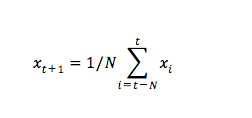                  


In other words, you say the prediction at t+1 is the average value of all the stock prices you observed within a window of t to t−N.

In [18]:
train_data.size

3000

In [0]:
# window_size = 50
# N =  len(train_data)
# std_avg_predictions = []
# std_avg_x = []
# mse_errors = []

# for pred_idx in range(window_size, N):
#   if pred_idx>= N:
    

In [35]:
window_size = 50
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    # storing Date of Prediction
    date = stock_df.loc[pred_idx,'Date']
    std_avg_x.append(date)

    # Storing Corresponing Prediction
    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    # Calculating Squared error
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    
print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for standard averaging: 0.00743


Take a look at the averaged results below. It follows the actual behavior of stock quite closely. Next, you will look at a more accurate one-step prediction method.



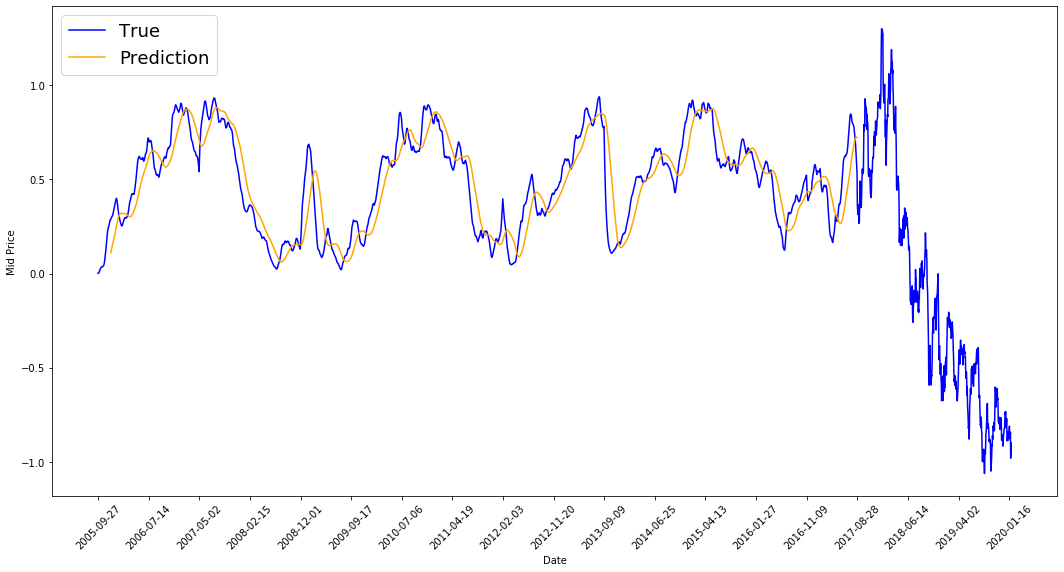

In [22]:
plt.figure(figsize = (18,9))
plt.plot(range(stock_df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
plt.xticks(range(0,stock_df.shape[0],200),[i.date() for i in stock_df['Date'].loc[::200]],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

So what do the above graphs (and the MSE) say?

It seems that it is not too bad of a model for very short predictions (one day ahead). Given that stock prices don't change from 0 to 100 overnight, this behavior is sensible. Next, you will look at a fancier averaging technique known as exponential moving average

### 2. **Exponential Moving Average**
You might have seen some articles on the internet using very complex models and predicting almost the exact behavior of the stock market. But beware! These are just optical illusions and not due to learning something useful. You will see below how you can replicate that behavior with a simple averaging method.

In the exponential moving average method, you calculate x[t+1] as:


         x[t+1] = EMA[t] = γ × EMA[t-1] + (1-γ) x[t] where EMA[0] = 0 and EMA is the exponential moving average value you maintain over time.
                

- The above equation basically calculates the exponential moving average for t time step i.e EMA[t] and uses that as the  one step ahead prediction i.e. x[t+1]. 
- γ decides what the contribution of the most recent prediction is to the EMA. For example, a γ=0.1 gets only 10% of the current value into the EMA. Because you take only a very small fraction of the most recent, it allows to preserve much older values you saw very early in the average. 

Let's See how this looks when used to predict one-step ahead below.


In [32]:
N = len(train_data)

run_avg_pred = []
run_avg_x = []

mse_errors = []

running_mean = 0
run_avg_pred.append(running_mean)

# model
decay = 0.5

for pred_idx in range(1,N):
  running_mean = running_mean*decay+(1.0-decay)*train_data[pred_idx-1]
  run_avg_pred.append(running_mean)
  mse_errors.append((run_avg_pred[-1]- train_data[pred_idx])**2)
  
  date = stock_df.loc[pred_idx,'Date']
  run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00013


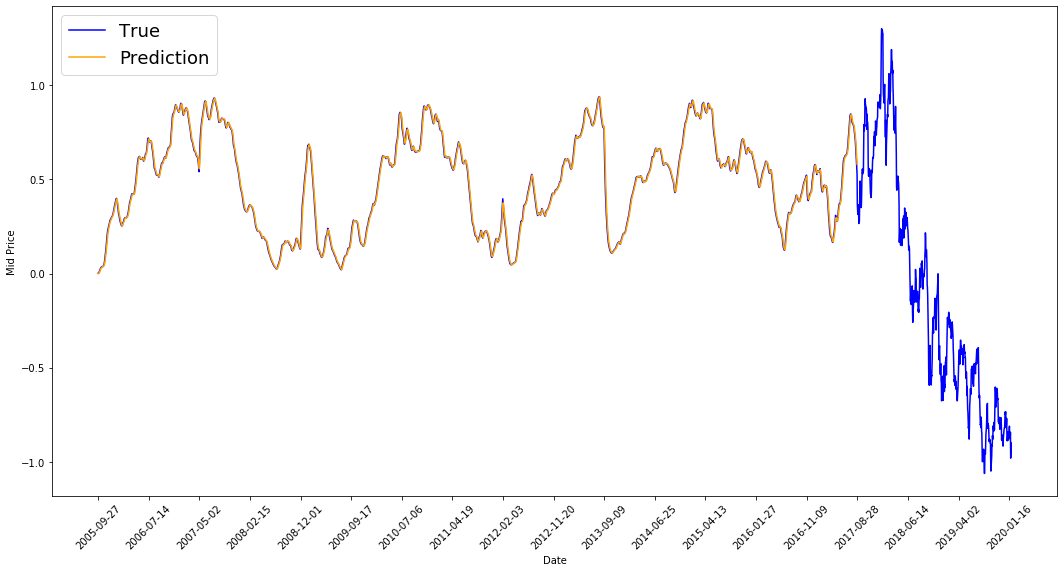

In [33]:
plt.figure(figsize = (18,9))
plt.plot(range(stock_df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_pred,color='orange',label='Prediction')
plt.xticks(range(0,stock_df.shape[0],200),[i.date() for i in stock_df['Date'].loc[::200]],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

If Exponential Moving Average is this Good, Why do You Need Better Models?

You see that it fits a perfect line that follows the True distribution (and justified by the very low MSE). Practically speaking, you can't do much with just the stock market value of the next day. Personally what I'd like is not the exact stock market price for the next day, but would the stock market prices go up or down in the next 30 days. Try to do this, and you will expose the incapability of the EMA method.

You will now try to make predictions in windows (say you predict the next 2 days window, instead of just the next day). Then you will realize how wrong EMA can go. Here is an example:-

**Predict More Than One Step into the Future**
To make things concrete, let's assume values, say x[t]=0.4, EMA[t-1]=0.5 and γ=0.5.
Let's calculate the value of x[t+1] using the equation:
     

```
      X[t+1] = EMA[t] = γ*EMA[t-1] + (1 - γ)*X[t]
# So you have:
      x[t+1] = EMA[t] = 0.5*0.5+(1−0.5)*0.4=0.45
      x[t+1] = EMA[t] = 0.45
# So the next prediction x[t+2] becomes,
      x[t+2] = γ*EMA[t] + (1-γ)*x[t+1]
# i.e.
      x[t+2] = γ*EMA[t]+(1−γ)*EMA[t]
      x[t+2] = EMA[t]
# Hence      
      X[t+2] = X[t+1] = 0.45
```



So no matter how many steps you predict in to the future, you'll keep getting the same answer for all the future prediction steps.

One solution you have that will output useful information is to look at **momentum-based algorithms**. They make predictions based on whether the past recent values were going up or going down (not the exact values). For example, they will say the next day price is likely to be lower, if the prices have been dropping for the past days, which sounds reasonable. However, you will use a more complex model: an LSTM model.

These models have taken the realm of time series prediction by storm, because they are so good at modelling time series data. You will see if there actually are patterns hidden in the data that you can exploit.

### **Introduction to LSTMs:**\
Long Short-Term Memory models are extremely powerful time-series models. They can predict an arbitrary number of steps into the future. An LSTM module (or cell) has 5 essential components which allows it to model both long-term and short-term data.